# 2021 가을학기 기계학습 프로젝트 - 2018320150 이유빈

## 1. 개요

 스마트폰이 전세계적으로 대중화되며, 모바일 게임 시장의 규모 또한 나날이 커지고 있다. 수많은 게임 회사에서 다양한 장르의 새로운 게임을 출시하지만, 어떤 게임은 좋은 평가를 받고 어떤 게임은 부정적인 평가를 받는다. 이는 앱스토어에 등록된 평점을 통해서 직관적으로 확인할 수 있다. 
 
 이번 프로젝트를 통해 게임의 장르, 제작사, 과금 요소, 출시 연도 등의 요소를 통해 게임의 평가를 예측하는 기계학습 모델을 MLPClassifier, K-Nearest Neighbors, BaggingClassifier를 이용하여 각각 구현하고 비교해보았다.

##2. Dataset 소개

사용한 Dataset은 kaggle에서 제공한 17K Mobile Strategy Games( https://www.kaggle.com/tristan581/17k-apple-app-store-strategy-games ) 로, 약 17000개의 instance와 총 18개의 feature를 가지고 있다.

> 들여쓴 블록





In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import files
uploaded = files.upload() #appstore_games.csv 파일을 디렉토리에서 직접 선택해서 코랩에 업로드하였다.

Saving appstore_games.csv to appstore_games.csv


In [3]:
origin_data = pd.read_csv('appstore_games.csv') #업로드된 csv파일을 불러온다.

origin_data.head()

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,https://apps.apple.com/us/app/sudoku/id284921427,284921427,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,https://apps.apple.com/us/app/reversi/id284926400,284926400,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,https://apps.apple.com/us/app/morocco/id284946595,284946595,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017
3,https://apps.apple.com/us/app/sudoku-free/id28...,285755462,Sudoku (Free),NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",21552128.0,Games,"Games, Strategy, Puzzle",23/07/2008,30/05/2017
4,https://apps.apple.com/us/app/senet-deluxe/id2...,285831220,Senet Deluxe,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...",34689024.0,Games,"Games, Strategy, Board, Education",18/07/2008,22/07/2018


In [4]:
origin_data.dtypes

URL                              object
ID                                int64
Name                             object
Subtitle                         object
Icon URL                         object
Average User Rating             float64
User Rating Count               float64
Price                           float64
In-app Purchases                 object
Description                      object
Developer                        object
Age Rating                       object
Languages                        object
Size                            float64
Primary Genre                    object
Genres                           object
Original Release Date            object
Current Version Release Date     object
dtype: object

이 중 label data로는 게임의 평점을 1에서 5 사이의 수로 나타내는 Average User Rating을 사용할 것이다. 평점에 영향을 미칠 것이라고 예상되는 Feature들엔 Price, In-app Purchases, Developer, Languages, Size, Genres, Original Release Date, Current Version Release Date가 있다. 각각의 Column들을 전처리하여 모델링에 사용할 것이다.

## 3. Preprocessing

In [5]:
data = origin_data
data = data[['Average User Rating', 'Price', 'In-app Purchases', 'Developer', 'Languages', 'Size', 'Genres', 'Original Release Date', 'Current Version Release Date']]

###In-app Purchases

In-app Purchases는 게임이 포함한 결제 상품들의 가격들을 나타내고, 이러한 과금 요소가 없는 게임의 경우 NAN이 저장되어 있다. 이번 프로젝트에서는 과금 요소의 유/무를 feature로 사용하고자 한다.

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data['In-app Purchases'] = data['In-app Purchases'].fillna(0, axis=0)
data.loc[data['In-app Purchases'] != 0, 'In-app Purchases'] = 1

data = data.dropna() #이외의 결측값이 존재한다면 제거한다.
data['In-app Purchases'] = le.fit_transform(data['In-app Purchases'])
data['In-app Purchases'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

1    4618
0    2919
Name: In-app Purchases, dtype: int64

###Developer

Developer의 경우, 게임을 2개 이하로 만든 Developer를 전부 ETC로 분류하였다. 그후, 모델링을 위해 LabelEncoding을 해주었다. 대다수를 차지하는 ETC를 제외한 분포를 표로 나타내면 다음과 같다.

In [7]:

for i in data['Developer']:
  if data.loc[data['Developer'] == i, 'Developer'].count() < 3:
    data.loc[data['Developer'] == i, 'Developer'] = 'ETC'

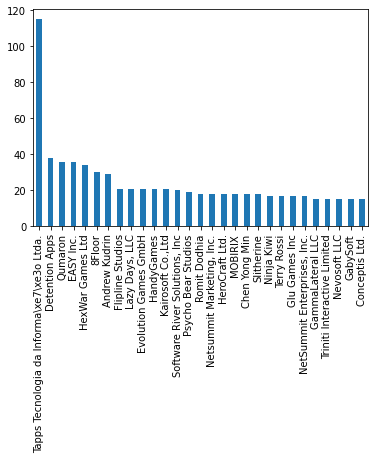

In [8]:
import matplotlib.pyplot as plt
data['Developer'].value_counts()[1:30].plot(kind = "bar")

data['Developer'] = le.fit_transform(data.Developer)

### Genres

장르의 경우, 한 instance 안에 여러 개의 장르를이 저장되어 있다. 먼저 이를 반점을 기준으로 순서대로 분리해준 후, 첫 번째 장르는 거의 항상 Games이므로 큰 의미를 가지지 않는다. 따라서 두 번째에 표기된 장르를 대표 장르로 채택하여 data['Genre']에 저장한다. 이후 모델링을 위해 LabelEncoding 한다. 

In [9]:
#장르를 ','을 기준으로 분할하였다.
Genres_split = data['Genres'].str.split(',')
Genres_split = Genres_split.apply(lambda x: pd.Series(x))
Genres_split


,0,1,2,3,4,5
0,Games,Strategy,Puzzle,NaN,NaN,NaN
1,Games,Strategy,Board,NaN,NaN,NaN
2,Games,Board,Strategy,NaN,NaN,NaN
3,Games,Strategy,Puzzle,NaN,NaN,NaN
4,Games,Strategy,Board,Education,NaN,NaN
...,...,...,...,...,...,...
16950,Games,Strategy,Entertainment,Puzzle,NaN,NaN
16956,Games,Entertainment,Action,Strategy,NaN,NaN
16962,Games,Simulation,Strategy,NaN,NaN,NaN
16967,Games,Simulation,Strategy,NaN,NaN,NaN


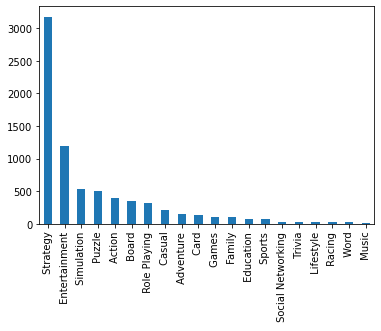

In [10]:
Genre1 = Genres_split.loc[:, 1]
data['Genre1'] = Genre1

data['Genre1'].value_counts()[:20].plot(kind = "bar")
data['Genre1'] = le.fit_transform(data.Genre1) # LabelEncoding

###Languages

Language 또한 Genre처럼 여러 개의 언어를 지원하는 게임의 경우도 있으므로 이를 분리해주고, 그 개수를 Feature로 사용하기 위해 새로운 column 'num_languages'를 추가하여 저장하였다.

In [11]:
Languages_split =  data['Languages'].str.split(',')
num_languages = []
for i in Languages_split:
  num_languages.append(len(i))
data['num_languages'] = num_languages

###Size

게임의 용량을 나타내는 Size의 단위가 byte이기 때문에 너무 큰 숫자로 나타나여, 이를 1048576으로 나누어 메가바이트로 환산해주었다. 

In [12]:
data['Size'] = data['Size'] / 1048576  #1MB = 2^20 Bytes

###Original Release Date, Current Version Release Date

월, 일까지 반영하면 종류가 지나치게 많아지므로, 출시일/최종 업데이트일의 연도만 추출하여 사용하였다. 이후 모델링을 위해 LabelEncoding을 진행하였다.

In [13]:
release_split = data['Original Release Date'].str.split('/')
release_split = release_split.apply(lambda x: pd.Series(x))

current_split = data['Current Version Release Date'].str.split('/')
current_split = current_split.apply(lambda x: pd.Series(x))

data['released_year'] = release_split.loc[:, 2]
data['cur_update_year'] = current_split.loc[:, 2]

data['released_year'] = le.fit_transform(data['released_year'])
data['cur_update_year'] = le.fit_transform(data['cur_update_year'])

### Average User Rating

기존 Average User Rating은 float의 형태로, 0.5 단위로 나타난다. 그 빈도 수의 분포는 아래와 같다.

In [14]:
data['Average User Rating'].value_counts()

4.5    2852
4.0    1719
5.0     986
3.5     923
3.0     513
2.5     314
2.0     156
1.5      60
1.0      14
Name: Average User Rating, dtype: int64

Average User Rating이 4.0 이상의 instance가 대부분을 차지하는 것을 확인할 수 있다. 이후 Classifier에 적용하기 쉽게 하기 위해서, 평점이 2.5 미만이면 부정적, 2.5이상 3.5이하이면 중립적, 그 이상이면 긍정적으로 범주화하였다. 즉, 평점이 1.0, 1.5, 2.0인 경우 1로, 2.5, 3.0, 3.5인 경우 2로, 4.0, 4.5, 5.0인 경우 3으로 replace해주었다.

In [15]:
data = data.replace({'Average User Rating' : {1.0 : 1, 1.5 : 1, 2.0 : 1, 2.5 : 2, 3.0 : 2, 3.5 : 2, 4.0 : 3, 4.5 : 3, 5.0 : 3}})

전처리를 모두 마친 dataset의 모양은 다음과 같다.

In [16]:
#사용할 feature들로 새로운 dataframe을 만든다.
data_model = data[['Price', 'In-app Purchases', 'Size', 'Genre1', 'Developer', 'num_languages', 'released_year', 'cur_update_year', 'Average User Rating']] 

data_model.head()

,Price,In-app Purchases,Size,Genre1,Developer,num_languages,released_year,cur_update_year,Average User Rating
0,2.99,0,15.119141,30,322,17,0,2017,3.0
1,1.99,0,11.757812,30,150,1,0,2018,2.0
2,0.00,0,0.643555,2,150,1,0,2017,2.0
3,0.00,0,20.553711,30,322,17,0,2017,2.0
4,2.99,0,33.082031,30,150,15,0,2018,2.0


##4. MLPClassifier


### Train-test split

dataset의 3분의 1을 Test set으로, 나머지를 Train set으로 split하였다.

In [17]:
from sklearn.model_selection import train_test_split

y = data_model[['Average User Rating']].to_numpy().ravel()
x = data_model.drop(columns=['Average User Rating'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3)

아무런 파라미터도 조정하지 않은 base MLPClassifier model을 생성하고 트레이닝하여 정확도를 확인하였다.

In [19]:
from sklearn.neural_network import MLPClassifier
base = MLPClassifier().fit(x_train, y_train)
base.score(x_test, y_test)

0.7144120247568524

###Adjusting the parameters
파라미터의 조절을 위해, lr_inits와 max_iters 배열을 만들어서 for문을 통해 가장 성능이 높은 파라미터들을 찾아보았다.

In [20]:
lr_inits = [0.0005, 0.001, 0.0015]
max_iters = [800, 1000, 1200]

from sklearn.model_selection import KFold
score = np.zeros((3, 3))
kf = KFold(n_splits=5) #Train data set의 5분의 1을 validation set으로 사용한다.

lr_index = 0
iter_index = 0
for learning_rate_init in lr_inits:
  iter_index = 0
  for max_iter in max_iters:
    mlp_accuracy = np.array([])
    for train_index, val_index in kf.split(x_train):
      x_train_cv, x_val_cv = x_train.iloc[train_index], x_train.iloc[val_index]
      y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
      mlp = MLPClassifier(learning_rate_init = learning_rate_init, max_iter = max_iter)
      mlp.fit(x_train_cv, y_train_cv)
      mlp_accuracy = np.append(mlp_accuracy, mlp.score(x_val_cv, y_val_cv))
    score[lr_index, iter_index] = mlp_accuracy.mean()
    iter_index += 1
  lr_index += 1    
score

array([[0.71753555, 0.63810427, 0.71241706],
       [0.70350711, 0.64056872, 0.73838863],
       [0.53023697, 0.62085308, 0.58635071]])

In [21]:
mlp = MLPClassifier(learning_rate_init = 0.0015, max_iter = 1200)
mlp.fit(x_train, y_train)
mlp.score(x_test, y_test)

0.7325375773651636

기존 base 모델보다 정확도가 올라간 것을 확인할 수 있다.

### Feature Selection

In [22]:
from sklearn.feature_selection import SelectKBest, chi2

X_new = SelectKBest(chi2, k=3).fit_transform(x, y)
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=.3)

score = MLPClassifier(learning_rate_init = 0.0015, max_iter = 1200).fit(x_train_new, y_train_new).score(x_test_new, y_test_new)
print(score)

0.748894783377542


Fiture Selection을 시행한 후 정확도가 기존의 training set을 사용하였을 때보다 높아진 것을 확인할 수 있다.

##5. K-Neighbors Classifier

두 번째로 선정한 모델은 sklearn에서 제공하는 KNeighborsClassifier이다. KNN Classifier를 모델로 선택한 이유는, 먼저 주어진 데이터셋에서 선형성을 찾기 힘들 거라고 생각하여 non-linear classifier인 KNN이 유리할 것이라고 예상했기 때문이다. 또, 데이터셋의 연관성에 대한 큰 이해가 없어도 학습 데이터들 간의 거리를 통해 예측을 진행하기 때문에 좀 더 편하게 학습이 가능할 것이라고 예측했다.

### Train-test split

dataset의 3분의 1을 Test set으로, 나머지를 Train set으로 split하였다.


In [23]:
from sklearn.model_selection import train_test_split

y = data_model[['Average User Rating']].to_numpy().ravel()
x = data_model.drop(columns=['Average User Rating'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3)

### Base Model

feature, parameter의 조정 없이 base 모델을 만들었고, 해당 모델의 정확도를 출력하였다.

In [24]:
from sklearn.neighbors import KNeighborsClassifier

base = KNeighborsClassifier()
base.fit(x_train, y_train)

base.score(x_test, y_test)

0.7219274977895668

### Adjusting the parameters
모델 파라미터 중 n_neighbors의 조절을 위해 corss validation을 사용하였다. validation accuracy들의 평균이 가장 높은 n_neighbors 값을 선정하기 위해 for문을 사용하였다.

In [25]:
from sklearn.model_selection import KFold

n_neighbors_list = [7, 9, 11, 13, 15, 17, 19, 21, 25, 27]
score = []

kf = KFold(n_splits=5) #Train data set의 5분의 1을 validation set으로 사용한다.
for k in n_neighbors_list:
  knn_accuracy = np.array([])
  for train_index, val_index in kf.split(x_train):
    x_train_cv, x_val_cv = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_cv, y_train_cv)
    knn_accuracy = np.append(knn_accuracy, knn.score(x_val_cv, y_val_cv))
  score = np.append(score, knn_accuracy.mean())
score


array([0.7228436 , 0.72758294, 0.72890995, 0.72872038, 0.73156398,
       0.73725118, 0.7385782 , 0.73914692, 0.74047393, 0.74085308])

In [26]:
print(np.argmax(score))

9


가장 성능이 높은 모델의 n_neighbors = 27이다.

In [27]:
knn = KNeighborsClassifier(n_neighbors=27)
knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.7462422634836428

base model의 score에 비해 성능이 더 좋아진 것을 확인할 수 있다.

###Feature Selection

영향력이 높은 feature 3개를 고르기 위해 Feature sklearn에서 제공하는 SelectBest와 chi2 테스트를 활용하여 가장 영향력이 높은 3개의 feature로 이루어진 새로운 training dataset X_new를 생성하였다.

이후, 앞에서 뽑은 best parameter인 n_neighbors = 25를 파라미터로 가지는 KNNClassifier 모델을 선언하여 새로운 feature space로 training을 진행하고, 정확도가 올라간 것을 확인하였다.

In [28]:
from sklearn.feature_selection import SelectKBest, chi2

X_new = SelectKBest(chi2, k=3).fit_transform(x, y)
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=.3)

score = KNeighborsClassifier(n_neighbors=27).fit(x_train_new, y_train_new).score(x_test_new, y_test_new)
print(score)

0.7541998231653404


##6. Ensemble - Bagging (K-Neighbors Classifier)

BaggingClassifier에 KNeighborsClassifier(n_neighbors = 19) 모델을 50개 훈련하였다. 그리고 feature selection을 진행하기 전의 데이터와 후의 데이터를 각각 트레이닝하여 그 정확도를 비교해보았다.

In [29]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(KNeighborsClassifier(n_neighbors = 27), n_estimators=50, oob_score=True, n_jobs=-1, random_state=40)
bagging.fit(x_train, y_train)
bagging.score(x_test, y_test)

0.748894783377542

In [30]:
bagging.fit(x_train_new, y_train_new)
bagging.score(x_test_new, y_test_new)

0.75552608311229

feature selection을 진행한 데이터셋의 정확도가 더 높게 나온 것을 확인할 수 있다.

## 결론


가장 정확도가 높았던 것은 BaggingClassifier에서 feature selection을 시행한 데이터셋을 인풋으로 넣은 모델로, 75.55%의 정확도를 보였다.


**MLPClassifier**의 경우 일관된 성능이 나오지 않았는데, 이것은 사용한 데이터셋이 비선형적이었기 때문일 것이라고 추측할 수 있다. 그래서 이것을 근거로 비선형적 classifier인 **K-Neighbors classifier**를 사용하여 파라미터를 조정해보았고, 그것을 바탕으로 Ensemble 알고리즘의 **BaggingClassifier**를 사용하여 정확도를 비교하였다.


모델의 전처리에 있어 어려움을 겪었다. 먼저, 만든 게임의 개수가 1개, 2개인 developer가 전체 중 대다수를 차지하였고, 또 장르도 Strategy에 편향된 경향이 있어 게임의 장르라는 feature가 학습에 주는 영향력을 제대로 나타내기 어려웠다.


하지만 가지고 있던 데이터의 label이 3(긍정적)에 치우친 경향성이 있었기 때문에 1, 2의 라벨을 가진 데이터를 제대로 예측하는 모델의 생성이 어려웠을 것으로 추측한다. 이후 이 주제에 관해 추가 연구가 진행된다면, 좀 더 평점이 골고루 분포하는 dataset을 구하거나, 아니면 게임의 선호도를 더 정확하게 판단할 수 있는 label을 선정하는 것이 중요할 것이다.